In [4]:
%pip install --quiet -U langchain_openai langchain_core langgraph langgraph-prebuilt langchain-chroma langchain-community beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


## Chunking 

In [5]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI 
from langchain_chroma import Chroma

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
llm = ChatOpenAI(model="gpt-4o-mini")

vector_store = Chroma(
    collection_name="example_collection",
    embedding_function=embeddings,
    persist_directory="longterm_memory_db",
)

In [6]:
import bs4 
from langchain_community.document_loaders import WebBaseLoader 
from langchain_text_splitters import RecursiveCharacterTextSplitter 

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)

docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(docs)
chunks
# vector_store.add_documents(chunks)


USER_AGENT environment variable not set, consider setting it to identify your requests.


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refi

In [8]:
chunks[0]

Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refin

In [9]:
_ = vector_store.add_documents(documents=chunks)

## Retriever

In [10]:
results = vector_store.similarity_search(
    "What is task decompostion?",
    k=1,
)
results[0].page_content

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\nSelf-Reflection#'

In [11]:
from langchain_core.tools.retriever import create_retriever_tool

retriever = vector_store.as_retriever(search_kwargs={"k": 2})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_article_info_tool",
    description="Retrieve some information from Lilian Weng's article",
)

In [12]:
retriever.invoke("What is task decomposition?")

[Document(id='b217e0a7-fefc-4cf4-afc7-ab30323ec04c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of 

In [13]:
retriever_tool.invoke("What is task decomposition?")

'Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool, assuming the availability of domain-specific PDDL and a suitable planner which is common in certain robotic setups but not in many other domains.\nSelf-Reflection#\n\nCompo

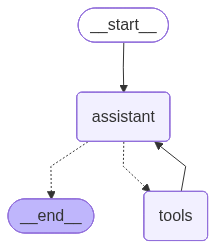

In [14]:
from pprint import pprint
from IPython.display import Image, display


from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


llm_with_tool = llm.bind_tools([retriever_tool])

# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tool.invoke(state["messages"])]}

# Build graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("assistant", assistant)
workflow.add_node("tools", ToolNode([retriever_tool]))

workflow.add_edge(START, "assistant")
workflow.add_conditional_edges(
    "assistant",
    tools_condition,
)
workflow.add_edge("tools", "assistant")

# Compile the graph
graph = workflow.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
results = graph.invoke(
    {"messages": "What is task decomposition?"}
)

In [16]:
results

{'messages': [HumanMessage(content='What is task decomposition?', additional_kwargs={}, response_metadata={}, id='896f4989-3b36-45a8-8be6-b9b57a41ac2e'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 64, 'total_tokens': 81, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CYp8V2kidAafq3vxqirGip30FdogN', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--434f4ae8-aa4c-4f9f-8a85-a0f67fb0abe3-0', tool_calls=[{'name': 'retrieve_article_info_tool', 'args': {'query': 'task decomposition'}, 'id': 'call_82bbNRgVSG04qJ7xA9Tm7VSM', 'type': 'tool_call'}], usage_metadata={'input_tokens': 64, 'ou

In [17]:
print(results["messages"][-1].content)

Task decomposition refers to the process of breaking down a complex task into smaller, more manageable sub-tasks or steps. This approach can be employed using various methods:

1. **Simple Prompting**: Language models (LLMs) can be prompted with questions like "Steps for XYZ" or "What are the subgoals for achieving XYZ?" to generate a list of steps.

2. **Task-Specific Instructions**: LLMs can be given specialized instructions tailored to specific tasks, such as "Write a story outline" for writing a novel.

3. **Human Inputs**: Human expertise can also be utilized to break down tasks effectively.

A more structured approach involves the use of an external classical planner, where the task is described using the Planning Domain Definition Language (PDDL). The process involves three main steps:
- Translating the task into “Problem PDDL.”
- Generating a PDDL plan through a classical planner based on existing “Domain PDDL.”
- Translating the generated PDDL plan back into natural language.
